# PS3: Kernelized Support Vector Machines (kSVMs)
In this problem set, we will experiment with a kernel Support Vector Machine (SVM) to classify challenging non-linearly separable datasets taken from the literature. In particular, we'll look at a kernelized version of the $\nu$-soft-margin support vector machine. If these terms are unfamiliar, [check out the L5c notes](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-5/L5c/docs/Notes.pdf) and the [this review](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf).

### Theory: Support Vector Machine (SVM)
Suppose we have dataset $\mathcal{D} = \{(\hat{\mathbf{x}}_{i}, y_{i}) \mid i = 1,2,\dots,n\}$, where $\hat{\mathbf{x}}_i \in \mathbb{R}^p$ is an _augmented_ feature vector ($m$ features with additional `1` to model the bias on the end of the vector) and $y_i \in \{-1, 1\}$ is the corresponding class label. The goal of an SVM (for binary classification tasks) is to find the hyperplane $\mathcal{H}(\hat{\mathbf{x}}) = \{\hat{\mathbf{x}} \mid \left<\hat{\mathbf{x}},\theta\right> = 0\}$ that separates the data points into two classes (those points above the hyperplane, and those points below the hyperplane), where $\theta \in \mathbb{R}^{p}$ ($p=m+1$) is the normal vector to the hyperplane, or the parameters of the model that we need to estimate.

#### $\nu$-Soft margin support vector machine
Today, we'll use a variant of the soft-margin support vector machine developed by Scholkopf et al. called the $\nu$-support vector classifier:
* [Scholkopf B, Smola AJ, Williamson RC, Bartlett PL. New support vector algorithms. Neural Comput. 2000 May;12(5):1207-45. doi: 10.1162/089976600300015565. PMID: 10905814.](https://pubmed.ncbi.nlm.nih.gov/10905814/)

This approach introduces a new parameter $\nu\in(0,1]$, where $\nu$ approximates the upper bound on the number of training mistakes. It also replaces the cost coefficient $C$
with a model of its value.  In this variant, the training problem (for $l$ training examples) is defined as: 
$$
\begin{align*}
    \min_{\theta}\quad & \frac{1}{2}\lVert{\theta}\rVert_{2}^{2} -\nu\rho+ \frac{1}{l}\sum_{i=1}^{n}\xi_{i}\\
    \text{subject to}\quad & y_{i}\left<\phi(\hat{\mathbf{x}}_{i}),\theta\right> \geq \rho - \xi_{i}\quad\forall i\\
    & \xi_{i} \geq 0\quad\forall{i}\quad\rho\geq{0}
\end{align*}
$$
where $\xi_{i}$ is a _slack variable_, that quantifies the cost of a classification mistake, and $\nu\in(0,1]$ is a user-defined hyperparameter. Notice, that $C\equiv{1/l}$ in this variant, thus, as $l\to\infty$ then $C\to{0}$. Finally, notice that we are applying the transformation $\phi:\mathbb{R}^{p}\to\mathbb{R}^{q}$ where $q>p$ to the input feature vector. This is done _implcitly_ when we select a [kernel function](https://en.wikipedia.org/wiki/Kernel_method).

### Tasks
Before you start, execute the `Run All Cells` command to check if you have any code or setup issues. Code issues, post them [to Ed Discussion](https://edstem.org/) - and let's get those fixed!

* __Task 1: Setup, Data, Constants__: Take a few minutes to explore the datasets we'll explore in the problem set. You can specify the number of training and test examples to train and test your SVM.
* __Task 2: Linear SVM classification__: In this task, [use the SVM implementation exported by the `LIBSVM.jl` package](https://github.com/JuliaML/LIBSVM.jl) to classify the dataset $\mathcal{D}$ generated in task 1 using a `radial basis` kernel. In particular, we use the `training` dataset to estimate the unknown model parameters $\theta$ [using the `svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl), and the `test` data to evaluate the performance of the classifier on unseen data [using the `svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl). We'll use the default values for the $\gamma$ and $\nu$ parameters.
* __Task 3: Implement a Grid Search to estimate the optimal hyperparameters for an RBF-SVM__: In this task, perform a grid search to estimate the best hyperparameters for a kernel SVM using the RBF kernel. We'll estimate the best $\nu$ parameter in the objective function and the length-scale $\gamma$ parameter.

Tests throughout the notebook (and at the bottom section) help you determine if things are running correctly. Let's go!!! (Don't forget to answer the discussion questions).

## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as external packages, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl");

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (2), incompatible header (12), dep missing source (4))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (6), incompatible header (12))
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] (cache misses: wrong dep version loaded (2), incompatible header (16))
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c] (cache misses: wrong dep version loaded (6), incompatible header (14))
[ Info: Precompiling LIBSVM [b1bec4e5-fd48-53fe-b0cb-9723c09d164b] (cache misses: incompatible header (4))
[ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0] (cache misses: wrong dep version loaded (4), incompatible header (14))
[ Info: Precompiling DistributionsChainRulesCoreExt [6db1f127-056a-568b-bd49-ae61d42389fa] (cache misses: wrong dep version loaded (4), incompatible header (14))
[ Info: Precomp

### Data
In this section, we'll load [a dataset from the `LIBSVM` data archive](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/) that describes the detection on non-coding RNA sequence that was initially published by:
* [Andrew V Uzilov, Joshua M Keegan, and David H Mathews. Detection of non-coding RNAs on the basis of predicted secondary structure formation free energy change.
BMC Bioinformatics, 7(173), 2006.](https://pubmed.ncbi.nlm.nih.gov/16566836/)


Non-coding RNAs (ncRNAs) have many roles in cells. However, detecting novel ncRNAs in biochemical screens is challenging. Accurate computational methods for detecting ncRNAs in sequenced genomes are essential to understanding the roles ncRNAs play in cells. In this dataset, there are:

* _What's in the dataset_? There are `59535` training instances in the `training` data; each instance has `8` continuous features and a binary label $y\in\left\{-1,1\right\}$. The `test` dataset has `271617` instances (with the same `8` continuous features and a binary label).

We begin by loading the `training` and `test` datasets. The [`LIBSVM` library authors](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/) have developed these subsets. However, we'll need to preprocess both the `training` and `test` sets. Before we do this, we'll set some constants. Please look at the comment next to the constant for a definition of what it is, units, permissible values, etc.

In [5]:
number_of_training_examples = 10000; # TODO: Set a value; has to be even, less than the 59535. *Warning* the larger, the slower this will run
number_of_test_examples = 100; # TODO Set a value; has to be even 271617. *Warning* the larger, the slower this will run.
number_of_features = 8; # there are eight continuous features

`Unhide` the code block below to see how we preprocessed the `training` dataset. We have [z-score centered](https://en.wikipedia.org/wiki/Standard_score) the training data and combined it into an array where each row is a training instance, while the first `1:number_of_features` columns hold the features. The last column has the label. 

We store the training data in the `training::Array{Float64,2}` array:

In [7]:
training = let

    # load the training data -
    data = parser(joinpath(_PATH_TO_DATA, "cod-rna-training.data"));
    number_of_rows = size(data,1);
    data_perm = range(1,stop=number_of_rows,step=1) |> collect |> i-> shuffle!(i);
    X = data[data_perm,:];
    
    # z-score center the data -
    μ = mean(X[:,1:number_of_features],dims=1);
    σ = std(X[:,1:number_of_features],dims=1);
    X̂ = zeros(number_of_rows,number_of_features+1);
    for i ∈ 1:number_of_rows
        for j ∈ 1:number_of_features
            X̂[i,j] = (X[i,j] - μ[j])/(σ[j]);
        end
        X̂[i,end] = X[i,end]; # get the label
    end

    # Finally, let's make sure the labels are balanced -
    yₒ = 1;
    is_ok_to_loop = true;
    tmp = Set{Array{Float64,1}}();
    while (is_ok_to_loop == true)
        i = rand(1:number_of_rows); # generate a random index
        y = X̂[i,end]
        if (y == yₒ)
            x = X̂[i,:];
            push!(tmp,x);
        end

        if (length(tmp) ≥ round(number_of_training_examples/2))
            is_ok_to_loop = false; # stop
        end
    end

    yₒ = -1;
    is_ok_to_loop = true;
    while (is_ok_to_loop == true)
        i = rand(1:number_of_rows); # generate a random index
        y = X̂[i,end]
        if (y == yₒ)
            x = X̂[i,:];
            push!(tmp,x);
        end

        if (length(tmp) ≥ number_of_training_examples)
            is_ok_to_loop = false; # stop
        end
    end
    
    D = Array{Float64,2}(undef, number_of_training_examples, (number_of_features + 1));
    for i ∈ 1:number_of_training_examples
        x = pop!(tmp);
        for j ∈ 1:(number_of_features + 1)
            D[i,j] = x[j];
        end
    end

    D; # return scaled - balanced data
end;

`Unhide` the code block below to see how we preprocessed the `test` dataset.  We have [z-score centered](https://en.wikipedia.org/wiki/Standard_score) the test data and combined it into an array where each row is a test instance, while the first `1:number_of_features` columns hold the features. The last column has the label.

We store the training data in the `test::Array{Float64,2}` array:

In [9]:
test = let

    data = parser(joinpath(_PATH_TO_DATA, "cod-rna-testing.data"));
    number_of_rows = size(data,1);
    data_perm = range(1,stop=number_of_rows,step=1) |> collect |> i-> shuffle!(i);
    X = data[data_perm,:];
    
    # z-score center the data -
    μ = mean(X[:,1:number_of_features],dims=1);
    σ = std(X[:,1:number_of_features],dims=1);
    X̂ = zeros(number_of_rows,number_of_features+1);
    for i ∈ 1:number_of_rows
        for j ∈ 1:number_of_features
            X̂[i,j] = (X[i,j] - μ[j])/(σ[j]);
        end
        X̂[i,end] = X[i,end]; # get the label
    end

    # Finally, let's make sure the labels are balanced -
    yₒ = 1;
    is_ok_to_loop = true;
    tmp = Set{Array{Float64,1}}();
    while (is_ok_to_loop == true)
        i = rand(1:number_of_rows); # generate a random index
        y = X̂[i,end]
        if (y == yₒ)
            x = X̂[i,:];
            push!(tmp,x);
        end

        if (length(tmp) ≥ round(number_of_test_examples/2))
            is_ok_to_loop = false; # stop
        end
    end

    yₒ = -1;
    is_ok_to_loop = true;
    while (is_ok_to_loop == true)
        i = rand(1:number_of_rows); # generate a random index
        y = X̂[i,end]
        if (y == yₒ)
            x = X̂[i,:];
            push!(tmp,x);
        end

        if (length(tmp) ≥ number_of_test_examples)
            is_ok_to_loop = false; # stop
        end
    end
    
    D = Array{Float64,2}(undef, number_of_test_examples, (number_of_features + 1));
    for i ∈ 1:number_of_test_examples
        x = pop!(tmp);
        for j ∈ 1:(number_of_features + 1)
            D[i,j] = x[j];
        end
    end

    D; # return scaled - balanced data
end;

## Task 2: Classification using an Default RBF-SVM
In this task, we [use the SVM implementation exported by the `LIBSVM.jl` package](https://github.com/JuliaML/LIBSVM.jl) to classify the dataset $\mathcal{D}$ generated in task 1 using a `radial basis kernel`. In particular, we use the `training` dataset to estimate the unknown model parameters $\theta$ [using the `svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl), and the `test` data to evaluate the performance of the classifier on unseen data [using the `svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl). We'll use the default values for the hyperparameters $\gamma$ and $\nu$.
* The [`svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) takes an augmented training examples matrix $\hat{\mathbf{X}}^{\top}$ where the examples are on the columns and the features are the rows, and a label vector $\mathbf{y}\in\left\{-1,1\right\}$.
* The [`svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) returns a [model instance](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) that holds the trained data and a bunch of other data associated with the problem.
* __Hmmm__: One of the (super) interesting optional arguments [the `svmtrain(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) is the `kernel` argument. Check out the documentation to see what kernels are supported! Wow! we get [kernelized SVM capability](https://en.wikipedia.org/wiki/Support_vector_machine#Nonlinear_kernels) right out of the box. _Buy versus build, 99% buy!_

In [11]:
model = let

    model = nothing; # default
    
    # Setup the data that we are using
    D = training; # what dataset are we looking at?
    number_of_examples = size(D,1); # how many rows?
    X = [D[:,1:end-1] ones(number_of_examples)] |> transpose |> Matrix; # augmented features (arranged as m x n)
    y = D[:,end]; # label

    # TODO: Uncomment the line below to train the SVM model using the training data 
    model = svmtrain(X, y, kernel=LIBSVM.Kernel.RadialBasis, verbose = false, svmtype = LIBSVM.NuSVC, nt = -1); # we are using the LIBSVM

    # return
    model
end;

__Inference__: Now that we have parameters estimated from the `training` data, we can use those parameters on the `test` dataset to see how well the model can differentiate between an actual banknote and a forgery on data it has never seen. We run the classification operation on the (unseen) test data [using the `svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl). 
* The [`svmpredict(...)` method](https://github.com/JuliaML/LIBSVM.jl/blob/master/src/LIBSVM.jl) returns the predicted label which we store in the `ŷ::Array{Int64,1}` array. We store the actual (correct) label in the `y::Array{Int64,1}` vector.

Finally, we compute the confusion matrix. The confusion matrix is a $2\times{2}$ matrix that contains four entries: true positive (TP), false positive (FP), true negative (TN), and false negative (FN). [Click me for a confusion matrix schematic!](https://github.com/varnerlab/CHEME-5820-Labs-Spring-2025/blob/main/labs/week-3/L3b/figs/Fig-BinaryConfusionMatrix.pdf). Let's compute these four values [using the `confusion(...)` method](src/Compute.jl) and store them in the `CM::Array{Int64,2}` variable.

In [13]:
ŷ,y,CM = let

    # Setup the data that we are using
    D = test; # HMMM: If we change test to training what are we calculating?
    number_of_examples = size(D,1); # how many rows?
    X = [D[:,1:end-1] ones(number_of_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y = D[:,end]; # label
    
    # TODO: Uncomment the line below to test the SVM model on the other block of the data.
    ŷ, decision_values = svmpredict(model, X);

    # compute the confusion matrix
    CM = confusion(y, ŷ) # call with the SVM test values
    
    # return -
    ŷ,y,CM
end;

In [14]:
number_of_test_points = length(y);
correct_prediction_perceptron = CM[1,1] + CM[2,2];
(correct_prediction_perceptron/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 0.45 Fraction incorrect 0.55


## Task 3: Implement a Grid Search to estimate the optimal hyperparameters for an RBF-SVM
In this task, we'll perform a grid search to estimate the best hyperparameters for a kernel SVM using the RBF kernel. We'll estimate the best $\nu$ parameter in the objective function and the length-scale $\gamma$ parameter. [A grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search) for kernel SVM parameters $\nu$ and $\gamma$ involves systematically exploring combinations of these hyperparameters to find the optimal configuration for model performance. Here's a description of the process:
* __Define parameter ranges__. For the $\nu$ parameter, we use $\nu\in[0,1)$ in steps of $\Delta\nu$, while for the length scale parameter $\gamma$, we use $\gamma\in\left\{2^{-15},2^{-13},\dots,2^{4}\right\}$ where we store the exponents (or values) in the `α::Array{Float64,1}` and `β::Array{Float64,1}` arrays, respectively.
* __Model training and evaluation__: For each parameter combination $(\nu_{i},\gamma_{j})$, we train an SVM model with an RBF kernel, compute the confusion matrix, and then evaluate the prediction accuracy. We save the accuracy data in the `A::Array{Float64,2}` array, where $a_{ij}\in\mathbf{A}$ holds the accuracy values for the parameter combination $(\nu_{i},\gamma_{j})$.

In [16]:
A, α, β = let

    # Training data setup -
    D₁ = training; # what dataset are we looking at?
    number_of_training_examples = size(D₁,1); # how many rows?
    X₁ = [D₁[:,1:end-1] ones(number_of_training_examples)] |> transpose |> Matrix; # augmented features (arranged as m x n)
    y₁ = D₁[:,end]; # label

    # Test data setup -
    D₂ = test; # what dataset are we looking at?
    number_of_test_examples = size(D₂,1); # how many rows?
    X₂ = [D₂[:,1:end-1] ones(number_of_test_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y₂ = D₂[:,end]; # label

    # setup the grid
    α = range(0.1,stop = 0.9, step=0.05) |> collect; # exponent for nu -
    β = range(-15,stop = 4, step=2) |> collect; # exponent for γ -
    number_of_points_nu = length(α);
    number_of_points_gamma = length(β);
    accuracy = Array{Float64,2}(undef, number_of_points_nu, number_of_points_gamma);

    # main loop
    for i ∈ eachindex(α)
        ν = α[i];
        for j ∈ eachindex(β)
            γ = 2.0^β[j];

            # TODO: Uncomment below to train the mode in the (C,γ) values -
            ŷ₂,_ = svmtrain(X₁, y₁, kernel=LIBSVM.Kernel.RadialBasis, 
                verbose = false, nu = ν, gamma = γ, nt = -1, svmtype = LIBSVM.NuSVC) |> model -> svmpredict(model,X₂);

            # how many mistakes?
            accuracy[i,j] = confusion(y₂, ŷ₂) |> CM -> CM[1,1] + CM[2,2] |> correct -> correct/number_of_test_examples;
        end

        # write a message -
        "Best value @i = $(i) equals $(maximum(accuracy))" |> println
    end
    
    accuracy, α, β
end;

Best value @i = 1 equals 76.0
Best value @i = 2 equals 76.0
Best value @i = 3 equals 76.0
Best value @i = 4 equals 76.0
Best value @i = 5 equals 76.0
Best value @i = 6 equals 76.0
Best value @i = 7 equals 76.0
Best value @i = 8 equals 76.0
Best value @i = 9 equals 76.0
Best value @i = 10 equals 76.0
Best value @i = 11 equals 76.0
Best value @i = 12 equals 76.0
Best value @i = 13 equals 76.0
Best value @i = 14 equals 76.0
Best value @i = 15 equals 71.0
Best value @i = 16 equals 71.0
Best value @i = 17 equals 0.61


[ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883] (cache misses: wrong dep version loaded (4), incompatible header (16))


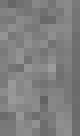

In [17]:
Gray.(1 .- A) # fun! More accurate parameter combinations are darker

In [18]:
do_I_see_the_accuracy_picture = true; # TODO: update this flag {true | false}

In [19]:
A # rows are nu, cols are γ

17×10 Matrix{Float64}:
 0.54  0.6   0.56  0.54  0.47  0.49  0.54  0.47  0.46  0.52
 0.49  0.48  0.52  0.54  0.52  0.56  0.51  0.53  0.46  0.54
 0.52  0.53  0.46  0.48  0.51  0.59  0.58  0.5   0.48  0.54
 0.49  0.44  0.47  0.52  0.53  0.48  0.46  0.46  0.46  0.54
 0.42  0.53  0.5   0.46  0.51  0.51  0.44  0.49  0.47  0.57
 0.49  0.47  0.51  0.44  0.48  0.45  0.55  0.51  0.49  0.56
 0.52  0.47  0.43  0.49  0.5   0.54  0.49  0.52  0.51  0.57
 0.5   0.47  0.42  0.55  0.48  0.51  0.45  0.51  0.5   0.57
 0.49  0.54  0.56  0.42  0.46  0.45  0.39  0.55  0.51  0.57
 0.52  0.48  0.45  0.48  0.49  0.51  0.46  0.56  0.53  0.57
 0.52  0.4   0.47  0.44  0.53  0.55  0.52  0.54  0.53  0.58
 0.45  0.41  0.47  0.45  0.48  0.51  0.49  0.49  0.53  0.58
 0.51  0.4   0.42  0.45  0.46  0.61  0.47  0.48  0.53  0.57
 0.48  0.44  0.47  0.48  0.45  0.56  0.47  0.49  0.49  0.58
 0.58  0.55  0.41  0.52  0.57  0.52  0.52  0.45  0.47  0.58
 0.53  0.53  0.45  0.48  0.43  0.57  0.51  0.44  0.45  0.57
 0.52  0.52  0.46

### What is the best SVM model?
Let's find the model with the highest training accuracy. We'll call this the _best model_ and save it in the `best_model::LIBSVM.SVM` variable. First, which element of the accuracy matrix $\mathbf{A}$ holds the maximum?
* We can estimate maximum accuracy element of the matrix $\mathbf{A}$ [using the `maximum(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.maximum). The `(i,j)` position of the maximum element can be computed using [the `argmax(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.argmax). The [`argmax(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.argmax) returns a cool data structure [called a `CartesianIndex`](https://docs.julialang.org/en/v1/base/arrays/#Base.IteratorsMD.CartesianIndex) which holds the (`row, col`) values of the maximum. This data structure is a way to model collection indices (which seems interesting!)

In [21]:
coordinate = argmax(A)
best_accuracy = maximum(A)
println("Best test accuracy: $(best_accuracy)")

Best test accuracy: 0.61


Next, get the best parameters and save these in the `ν_best::Float64` and `γ_best::Float64` variables:

In [23]:
ν_best, γ_best = let
    
    ν = coordinate[1] |> i-> α[i]; # Wow! we grab the row (corresponds to ν)
    γ = coordinate[2] |> i-> β[i] |> e-> 2.0^e; # Nice! grab the col (corresponds to γ), get the exponent from β, and then compute the value

    ν,γ
end;

Finally, estimate the `best_model::LIBSVM.SVM`, the best predicted label vector `ŷ_test_best::Array{Int64,1}`, and the actual label vector `y_test::Array{Int64,1}` using the best parameters:

In [25]:
best_model, ŷ_test_best, y_test = let

    # Training data setup -
    D₁ = training; # what dataset are we looking at?
    number_of_training_examples = size(D₁,1); # how many rows?
    X₁ = [D₁[:,1:end-1] ones(number_of_training_examples)] |> transpose |> Matrix; # augmented features (arranged as m x n)
    y₁ = D₁[:,end]; # label

    # Test data setup -
    D₂ = test; # what dataset are we looking at?
    number_of_test_examples = size(D₂,1); # how many rows?
    X₂ = [D₂[:,1:end-1] ones(number_of_test_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y₂ = D₂[:,end]; # label

    # estimate the best model -
    best_model = svmtrain(X₁, y₁, kernel=LIBSVM.Kernel.RadialBasis, 
                    verbose = false, nu = ν_best, gamma = γ_best, svmtype = LIBSVM.NuSVC)
    

    # compute the ŷ_best -
    ŷ_best, _ = svmpredict(best_model,X₂);

    # return -
    best_model, ŷ_best, y₂
end;

Confirm the accuracy of the `best_model::LIBSVM.`:

In [27]:
accuracy_best_confirm = confusion(y_test, ŷ_test_best) |> CM -> CM[1,1] + CM[2,2] |> correct -> correct/size(test,1) # impressive!
@assert best_accuracy == accuracy_best_confirm

## Discussion questions

__DQ1__: Compute the `training` accuracy (hmmm, how do I do that?) and compare it to the `test` accuracy. Which is larger, and is this what you expected?

In [30]:
## Put your answer to DQ1 (either as a commented code cell, or as a markdown cell)

In [31]:
training_accuracy = let

    # Setup the data that we are using
    D = training; # HMMM: If we change test to training what are we calculating?
    number_of_examples = size(D,1); # how many rows?
    X = [D[:,1:end-1] ones(number_of_examples)] |> transpose |> Matrix; # features (arranged as m x n)
    y = D[:,end]; # label

    # TODO: Uncomment the line below to train the SVM model using the training data 
    model = svmtrain(X, y, kernel=LIBSVM.Kernel.RadialBasis, verbose = false, svmtype = LIBSVM.NuSVC, nt = -1); # we are using the LIBSVM
    
end

LIBSVM.SVM{Float64, LIBSVM.Kernel.KERNEL}(NuSVC, LIBSVM.Kernel.RadialBasis, nothing, 9, 10000, 2, [1.0, -1.0], Int32[1, 2], Float64[], Int32[], LIBSVM.SupportVectors{Vector{Float64}, Matrix{Float64}}(7410, Int32[3736, 3674], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [-0.005417253659371857 0.8491818246554698 … -0.7175831522550732 -0.31666012786045616; 1.0360868582888236 -1.142024944334403 … 0.9897440539776912 1.0360868582888236; … ; -0.6145547615228867 0.7432467250972159 … 2.147695864695112 0.699463632217777; 1.0 1.0 … 1.0 1.0], Int32[1, 2, 3, 4, 5, 6, 8, 10, 12, 14  …  9962, 9969, 9973, 9975, 9978, 9984, 9986, 9993, 9998, 10000], LIBSVM.SVMNode[LIBSVM.SVMNode(1, -0.005417253659371857), LIBSVM.SVMNode(1, 0.8491818246554698), LIBSVM.SVMNode(1, -1.1079555707445687), LIBSVM.SVMNode(1, 1.1498740929514326), LIBSVM.SVMNode(1, 0.1159147142495254), LIBSVM.SVMNode(1, 0.5379389504543854), LIBSVM.SVMNode(1, 0.8333559157977874

In [32]:
did_I_answer_DQ1 = true;

__DQ2__: Did the grid search improve the `test` accuracy compared with the default parameters? If not, brainstorm a few ideas about what we could do to improve the `test` accuracy and if so, what can we do to improve further?

In [34]:
## Put your answer to DQ2 (either as a commented code cell, or as a markdown cell)

In [35]:
did_I_answer_DQ2 = true;

__DQ3__: Hmmm. Smaller `test` sets seem to give better predictions. Many questions. Why might this be the case?
For example, are we missing more in a particular direction, or are the `test` data examples that we are missing outliers in some way?  Brainstorm some (cheating?) data engineering strategies to jack up the prediction accuracy.

In [37]:
## Put your answer to DQ3 (either as a commented code cell, or as a markdown cell)

In [38]:
did_I_answer_DQ3 = true;

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [40]:
let 
    @testset verbose = true "CHEME 5820 problem set 3 test suite" begin
        
        @testset "Setup, Prerequisites and Data" begin
            @test _DID_INCLUDE_FILE_GET_CALLED == true
            @test number_of_training_examples > 0
            @test number_of_test_examples > 0
            @test size(training,1) == number_of_training_examples
            @test size(test,1) == number_of_test_examples
        end

        @testset "Default RBF-Kernel" begin
            @test isnothing(model) == false
            @test isnothing(CM) == false
        end

        @testset "Grid Search" begin
            @test isempty(A) == false
            @test isnothing(best_model) == false
            @test do_I_see_the_accuracy_picture == true
            @test isnothing(ŷ_test_best) == false
            @test isnothing(y_test) == false
        end

        @testset "Discussion questions" begin
            @test did_I_answer_DQ1 == true
            @test did_I_answer_DQ2 == true
            @test did_I_answer_DQ3 == true
        end
    end
end;

Test Summary:                       | Pass  Total  Time
CHEME 5820 problem set 3 test suite |   15     15  0.3s
  Setup, Prerequisites and Data     |    5      5  0.2s
  Default RBF-Kernel                |    2      2  0.0s
  Grid Search                       |    5      5  0.0s
  Discussion questions              |    3      3  0.0s
